In [1]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

import hvplot.xarray
import hvplot
import cmocean

import matplotlib as mpl

hvplot.output(widget_location='bottom')

from helpers_mom6.collection_of_experiments import CollectionOfExperiments
from helpers_mom6.computational_tools import remesh, select_LatLon, Lk_error, x_coord, y_coord, gaussian_remesh
from helpers.plot_helpers import *
from helpers.selectors import *

import warnings
warnings.filterwarnings("ignore")


%load_ext autoreload
%autoreload 3

In [2]:
def KE(u,v,T):
    return 0.5*(remesh(u**2, T) + remesh(v**2,T))

In [11]:
# ZBu = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssu.nc', chunks={'time':1})
# ZBv = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.ssv.nc', chunks={'time':1})
# ZBT = xr.open_dataset('/vast/pp2681/ZB2020/ocean_daily.20080101-20121231.tos.nc', chunks={'time':1})

# loresu = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.ssu.nc', chunks={'time':1})
# loresv = xr.open_dataset('/vast/pp2681/unparameterized/ocean_daily.20080101-20121231.ssv.nc', chunks={'time':1})

# ZBke = KE(ZBu.ssu, ZBv.ssv, ZBT.tos)
# loreske = KE(loresu.ssu, loresv.ssv, ZBT.tos)

In [9]:
#ann_mar24 = xr.open_mfdataset('/scratch/pp2681/mom6/global_simulations/OM4_025.JRA/output/ocean_daily*', chunks={'time':1})
#ke_mar24 = KE(ann_mar24.ssu, ann_mar24.ssv, ZBT.tos)

In [3]:
ann_cs0 = xr.open_mfdataset('/scratch/pp2681/mom6/global_simulations/May16-Cs-0.00/output/ocean_daily*', chunks={'time':1})

In [3]:
ann_cs1 = xr.open_mfdataset('/scratch/pp2681/mom6/global_simulations/May16-Cs-0.01/output/ocean_daily*', chunks={'time':1})

In [5]:
ann_fct0 = xr.open_mfdataset('/scratch/pp2681/mom6/global_simulations/May16-FCT-0-Cs-0.00/output/ocean_daily*', chunks={'time':1})

In [6]:
ann_fct3 = xr.open_mfdataset('/scratch/pp2681/mom6/global_simulations/May16-FCT-3/output/ocean_daily*', chunks={'time':1})

In [4]:
#ke_cs0 = KE(ann_cs0.ssu, ann_cs0.ssv, ann_cs0.zos)
ke_cs1 = KE(ann_cs1.ssu, ann_cs1.ssv, ann_cs1.zos)
#ke_fct0 = KE(ann_fct0.ssu, ann_fct0.ssv, ann_fct0.zos)
#ke_fct3 = KE(ann_fct3.ssu, ann_fct3.ssv, ann_fct3.zos)

# Geostrophic velocities from data

In [8]:
from xgcm import Grid
def geostrophic_velocity(ds, ssh):
    '''
    ds contains coordinate information (xh, yh, xq, yq)
    ssh is an array in xh, yh points
    '''
    res = ds.xh[1] - ds.xh[0]
    grid = Grid(ds.drop_vars('time'), coords={
            'X': {'center': 'xh', 'right': 'xq'},
            'Y': {'center': 'yh', 'right': 'yq'}
            },
            periodic = 'X'
            )
    
    R = 6.371e+6 # Earth radius in metres|
    deg_to_rad = np.pi / 180 # degrees to radians factor
    dx = res * R * deg_to_rad * np.cos(ds.yh * deg_to_rad)
    dy = res * R * deg_to_rad
    g = 9.8
    Omega = 7.2921e-5
    fh = 2 * Omega * np.sin(ds.yh * deg_to_rad)
    fq = 2 * Omega * np.sin(ds.yq * deg_to_rad)
    
    # Gradient of the SSH
    hx = grid.diff(ssh, 'X') / dx
    hy = grid.diff(ssh, 'Y') / dy
    
    u = grid.interp(- g / fq * hy, 'Y')
    v = grid.interp(+ g / fh * hx, 'X')
    return u, v

In [9]:
obs = xr.open_dataset('/vast/pp2681/altimetry_Copernicus.nc', chunks={'time':1}).rename({'longitude': 'xh', 'latitude': 'yh'})
res = 0.25
xq = np.array(obs['xh'] + res / 2)
obs['xq'] = xr.DataArray(xq, dims='xq', coords={'xq': xq})

yq = np.array(obs['yh'] + res / 2)
obs['yq'] = xr.DataArray(yq, dims='yq', coords={'yq': yq})
ug, vg = geostrophic_velocity(obs, obs.adt)

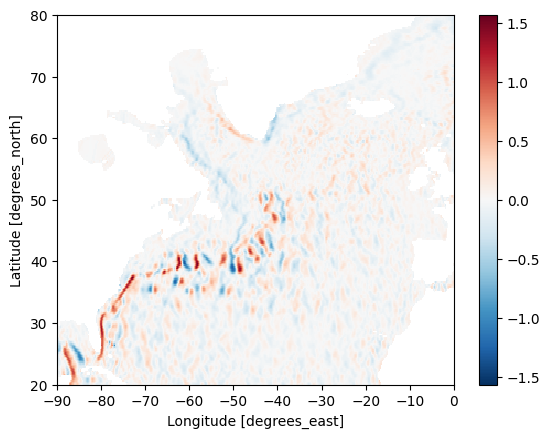

In [10]:
vg.sel(xh=slice(-90,0), yh=slice(20,80)).isel(time=-1).plot()

In [11]:
obskeg = (ug**2 + vg**2) * 0.5

# Plotting velocities

## Selecting 2008 year for most 

In [13]:
#ZBu.time[0:2]

In [14]:
obs.isel(time=slice(5478,None)).time[0:2]

<xarray.DataArray 'time' (time: 2)>
array(['2008-01-01T00:00:00.000000000', '2008-01-02T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2008-01-01 2008-01-02
Attributes:
    standard_name:  time
    long_name:      Time
    axis:           T

In [15]:
ann_cs0.time[0:2]

<xarray.DataArray 'time' (time: 2)>
array([cftime.DatetimeJulian(1, 1, 1, 12, 0, 0, 0, has_year_zero=False),
       cftime.DatetimeJulian(1, 1, 2, 12, 0, 0, 0, has_year_zero=False)],
      dtype=object)
Coordinates:
  * time     (time) object 0001-01-01 12:00:00 0001-01-02 12:00:00
Attributes:
    long_name:       time
    cartesian_axis:  T
    calendar_type:   JULIAN
    bounds:          time_bnds

In [17]:
OBS_vg = np.sqrt(2*obskeg.isel(time=slice(5478,None)))
#ZB_v = np.sqrt(2*ZBke)
#LORES_v = np.sqrt(2*loreske)
#ann_v = np.sqrt(2*annke)
cs0_v = np.sqrt(2*ke_cs0)
cs1_v = np.sqrt(2*ke_cs1)
fct0_v = np.sqrt(2*ke_fct0)
fct3_v = np.sqrt(2*ke_fct3)

In [18]:
xh = OBS_vg['xh']
xh = xr.where(xh>60, xh-360,xh)
OBS_vg['xh'] = xh
OBS_vg = OBS_vg.sortby('xh')

In [35]:
default_rcParams({'figure.subplot.wspace': 0.1, 'font.size': 20})
def plot_regions(idx=0, lat=slice(20,70), lon=slice(-90,0)):
    fig, axes = plt.subplots(2,3,figsize=(12,8), 
    subplot_kw={'projection': ccrs.Orthographic(central_latitude=(lat.start+lat.stop)/2, central_longitude=(lon.start+lon.stop)/2)})
    
    time_idx=idx
    time_str_simple = cs0_v.time.isel(time=time_idx).item().strftime('%m-%d')
    
    # My preset; Equivalent to plotting surface KE
    cmap = plt.get_cmap('inferno')
    norm = mpl.colors.LogNorm(vmin=0.05, vmax=1.5)
    cmap.set_bad('gray')
    
    ax = axes[0][0]
    ax.coastlines()
    ax.gridlines()
    im = cs0_v.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('ANN-Cs-0.00', fontsize=20)

    ax = axes[0][1]
    ax.coastlines()
    ax.gridlines()
    im = cs1_v.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('ANN-Cs-0.01', fontsize=20)

    ax = axes[1][0]
    ax.coastlines()
    ax.gridlines()
    im = fct0_v.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('ANN-FCT-0-Cs-0.00', fontsize=20)

    
    ax = axes[1][1]
    ax.coastlines()
    ax.gridlines()
    im = fct3_v.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('ANN-FCT-3', fontsize=20)

    ax = axes[0][2]
    ax.coastlines()
    ax.gridlines()
    im = OBS_vg.isel(time=time_idx).sel(xh=lon, yh=lat).plot(
        ax=ax, transform=ccrs.PlateCarree(),
        norm=norm,
        cmap=cmap,
        add_colorbar=False
    )
    ax.set_title('Obervations', fontsize=20)

    axes[1][2].set_axis_off()


    cb = plt.colorbar(im, pad=0.02, ax=axes, extend='both', aspect=100, shrink=1.0, orientation='horizontal')
    cb.set_label(label='Surface velocity, $\mathrm{m}/\mathrm{s}$')
    plt.suptitle(time_str_simple, y=0.95)

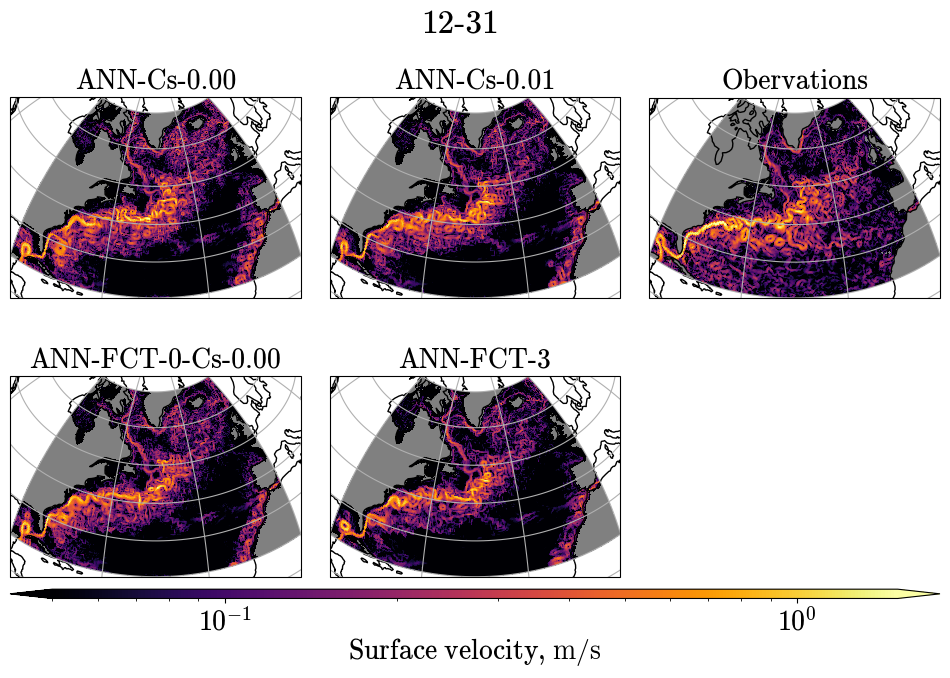

In [36]:
plot_Atlantic = lambda idx: plot_regions(idx=idx)
plot_Atlantic(364)

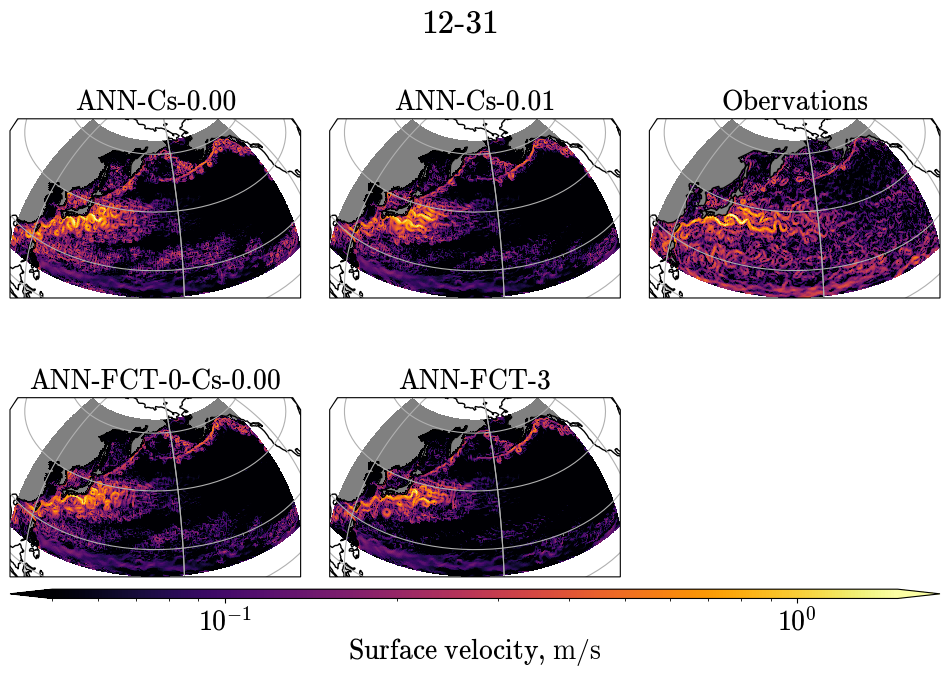

In [37]:
plot_Pacific = lambda idx: plot_regions(idx=idx, lat=slice(10,65), lon=slice(-250,-130))
plot_Pacific(364)

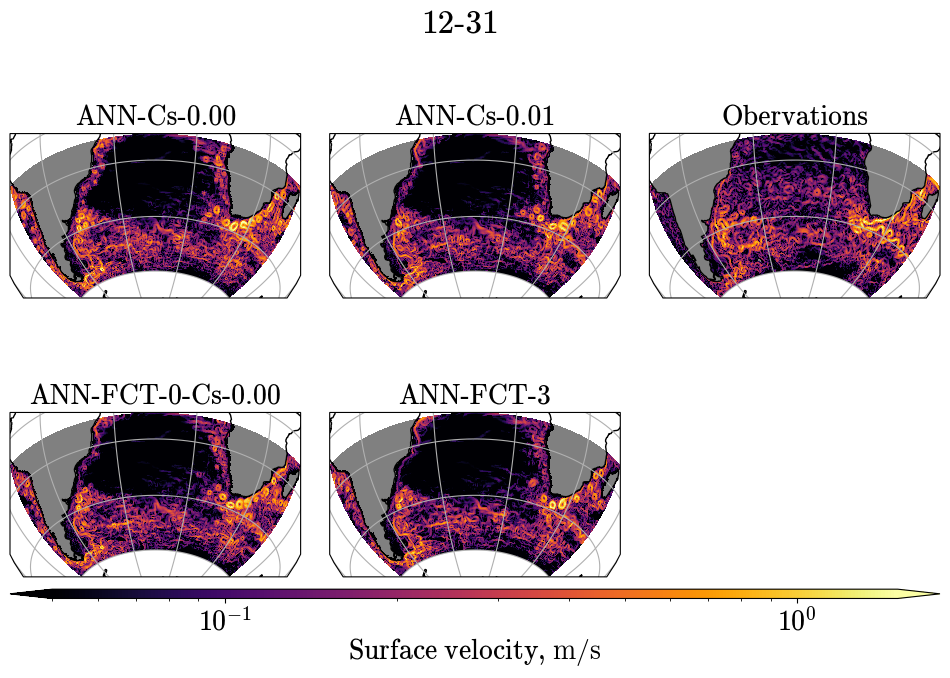

In [38]:
plot_rings = lambda idx: plot_regions(idx=idx, lat=slice(-60,-10), lon=slice(-80,50))
plot_rings(364)

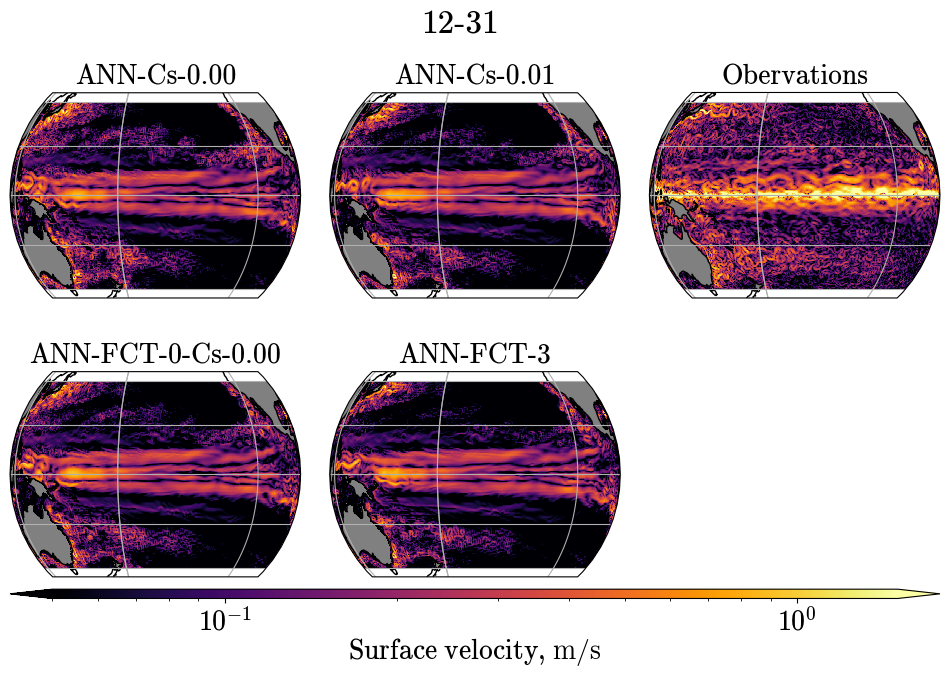

In [39]:
plot_equator = lambda idx: plot_regions(idx=idx, lat=slice(-40,40), lon=slice(-280,-50))
plot_equator(364)

In [41]:
%%time
create_animation_ffmpeg(plot_Atlantic, range(0,365,3), 'ANN_May16_Atlantic.mp4', dpi=200, FPS=20)

Native resolution of snapshots is used: 1900x1348

Animation ANN_May16_Atlantic.mp4 at FPS=20 will last for 6.1 seconds. The frames are saved to 
.ffmpeg/ANN_May16_Atlantic

Running the command:
cd /scratch/pp2681/MOM6-examples/src/MOM6/experiments/ANN-Results/offline_analysis; ffmpeg -y -framerate 20 -i .ffmpeg/ANN_May16_Atlantic/frame-%d.png -s:v 1900x1348 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ANN_May16_Atlantic.mp4


sh: 1: module: not found
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --en

CPU times: user 6min 19s, sys: 2min 30s, total: 8min 49s
Wall time: 6min 31s


frame=  122 fps= 25 q=-1.0 Lsize=    8008kB time=00:00:05.95 bitrate=11025.6kbits/s speed= 1.2x    
video:8006kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.023346%
[libx264 @ 0x556689c18400] frame I:1     Avg QP:16.94  size:226247
[libx264 @ 0x556689c18400] frame P:82    Avg QP:22.61  size: 86270
[libx264 @ 0x556689c18400] frame B:39    Avg QP:27.59  size: 23013
[libx264 @ 0x556689c18400] consecutive B-frames: 57.4%  0.0%  0.0% 42.6%
[libx264 @ 0x556689c18400] mb I  I16..4: 20.8% 45.1% 34.1%
[libx264 @ 0x556689c18400] mb P  I16..4:  0.0%  0.3%  0.4%  P16..4:  9.2%  5.5%  5.5%  0.0%  0.0%    skip:79.1%
[libx264 @ 0x556689c18400] mb B  I16..4:  0.1%  0.2%  0.1%  B16..8:  3.3%  1.0%  1.0%  direct: 6.3%  skip:88.2%  L0:30.5% L1:43.8% BI:25.7%
[libx264 @ 0x556689c18400] 8x8 transform intra:46.1% inter:29.1%
[libx264 @ 0x556689c18400] coded y,uvDC,uvAC intra: 47.0% 40.2% 38.0% inter: 12.4% 13.8% 12.9%
[libx264 @ 0x556689c18400] i16 v,h,dc,p: 63% 27% 10%  0

In [44]:
%%time
create_animation_ffmpeg(plot_Pacific, range(0,365,3), 'ANN_May16_Pacific.mp4', dpi=200, FPS=20)

Native resolution of snapshots is used: 1900x1348

Animation ANN_May16_Pacific.mp4 at FPS=20 will last for 6.1 seconds. The frames are saved to 
.ffmpeg/ANN_May16_Pacific

Running the command:
cd /scratch/pp2681/MOM6-examples/src/MOM6/experiments/ANN-Results/offline_analysis; ffmpeg -y -framerate 20 -i .ffmpeg/ANN_May16_Pacific/frame-%d.png -s:v 1900x1348 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ANN_May16_Pacific.mp4


sh: 1: module: not found
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --en

CPU times: user 7min 1s, sys: 2min 30s, total: 9min 32s
Wall time: 7min 1s


frame=  122 fps= 23 q=-1.0 Lsize=    6471kB time=00:00:05.95 bitrate=8909.3kbits/s speed=1.11x    
video:6469kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.027383%
[libx264 @ 0x55c12d042f80] frame I:1     Avg QP:17.84  size:193152
[libx264 @ 0x55c12d042f80] frame P:88    Avg QP:22.40  size: 66905
[libx264 @ 0x55c12d042f80] frame B:33    Avg QP:27.59  size: 16458
[libx264 @ 0x55c12d042f80] consecutive B-frames: 63.9%  0.0%  0.0% 36.1%
[libx264 @ 0x55c12d042f80] mb I  I16..4: 17.0% 55.3% 27.8%
[libx264 @ 0x55c12d042f80] mb P  I16..4:  0.1%  0.2%  0.2%  P16..4:  9.1%  5.7%  5.3%  0.0%  0.0%    skip:79.4%
[libx264 @ 0x55c12d042f80] mb B  I16..4:  0.1%  0.3%  0.0%  B16..8:  4.7%  1.6%  0.8%  direct: 4.1%  skip:88.4%  L0:32.3% L1:47.5% BI:20.1%
[libx264 @ 0x55c12d042f80] 8x8 transform intra:54.5% inter:34.1%
[libx264 @ 0x55c12d042f80] coded y,uvDC,uvAC intra: 38.8% 34.4% 32.3% inter: 11.3% 13.1% 11.3%
[libx264 @ 0x55c12d042f80] i16 v,h,dc,p: 51% 38% 10%  1%

In [45]:
%%time
create_animation_ffmpeg(plot_rings, range(0,365,3), 'ANN_May16_rings.mp4', dpi=200, FPS=20)

Frames already exists in folder .ffmpeg/ANN_May16_rings


Do you want to update snapshots?: [y/n] y


Native resolution of snapshots is used: 1900x1348

Animation ANN_May16_rings.mp4 at FPS=20 will last for 6.1 seconds. The frames are saved to 
.ffmpeg/ANN_May16_rings

Running the command:
cd /scratch/pp2681/MOM6-examples/src/MOM6/experiments/ANN-Results/offline_analysis; ffmpeg -y -framerate 20 -i .ffmpeg/ANN_May16_rings/frame-%d.png -s:v 1900x1348 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ANN_May16_rings.mp4


sh: 1: module: not found
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --en

CPU times: user 6min 46s, sys: 2min 30s, total: 9min 16s
Wall time: 1h 3min 25s


frame=  122 fps= 20 q=-1.0 Lsize=    8816kB time=00:00:05.95 bitrate=12138.4kbits/s speed=0.957x    
video:8815kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.016595%
[libx264 @ 0x55bf42d25f80] frame I:1     Avg QP:15.55  size:173060
[libx264 @ 0x55bf42d25f80] frame P:118   Avg QP:22.65  size: 74366
[libx264 @ 0x55bf42d25f80] frame B:3     Avg QP:27.93  size: 25886
[libx264 @ 0x55bf42d25f80] consecutive B-frames: 96.7%  0.0%  0.0%  3.3%
[libx264 @ 0x55bf42d25f80] mb I  I16..4: 25.5% 46.6% 27.8%
[libx264 @ 0x55bf42d25f80] mb P  I16..4:  0.0%  0.1%  0.1%  P16..4:  8.5%  5.0%  5.3%  0.0%  0.0%    skip:81.0%
[libx264 @ 0x55bf42d25f80] mb B  I16..4:  0.1%  0.7%  0.2%  B16..8:  5.9%  2.7%  1.9%  direct: 4.5%  skip:84.0%  L0:22.4% L1:63.7% BI:14.0%
[libx264 @ 0x55bf42d25f80] 8x8 transform intra:48.9% inter:31.5%
[libx264 @ 0x55bf42d25f80] coded y,uvDC,uvAC intra: 29.5% 23.0% 20.3% inter: 14.0% 16.4% 15.4%
[libx264 @ 0x55bf42d25f80] i16 v,h,dc,p: 72% 20%  8%  

In [46]:
%%time
create_animation_ffmpeg(plot_equator, range(0,365,3), 'ANN_May16_equator.mp4', dpi=200, FPS=20)

Frames already exists in folder .ffmpeg/ANN_May16_equator


Do you want to update snapshots?: [y/n] y


Native resolution of snapshots is used: 1900x1348

Animation ANN_May16_equator.mp4 at FPS=20 will last for 6.1 seconds. The frames are saved to 
.ffmpeg/ANN_May16_equator

Running the command:
cd /scratch/pp2681/MOM6-examples/src/MOM6/experiments/ANN-Results/offline_analysis; ffmpeg -y -framerate 20 -i .ffmpeg/ANN_May16_equator/frame-%d.png -s:v 1900x1348 -c:v libx264 -profile:v high -crf 20 -pix_fmt yuv420p ANN_May16_equator.mp4


sh: 1: module: not found
ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --en

CPU times: user 10min 15s, sys: 2min 30s, total: 12min 46s
Wall time: 12min 3s


frame=  122 fps= 19 q=-1.0 Lsize=    8473kB time=00:00:05.95 bitrate=11665.9kbits/s speed=0.921x    
video:8471kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.025293%
[libx264 @ 0x560195732c80] frame I:1     Avg QP:18.72  size:175689
[libx264 @ 0x560195732c80] frame P:52    Avg QP:21.91  size:117639
[libx264 @ 0x560195732c80] frame B:69    Avg QP:27.05  size: 34505
[libx264 @ 0x560195732c80] consecutive B-frames: 24.6%  0.0%  0.0% 75.4%
[libx264 @ 0x560195732c80] mb I  I16..4: 19.5% 58.8% 21.7%
[libx264 @ 0x560195732c80] mb P  I16..4:  0.2%  1.7%  1.1%  P16..4: 11.0%  9.9%  9.3%  0.0%  0.0%    skip:66.7%
[libx264 @ 0x560195732c80] mb B  I16..4:  0.1%  0.8%  0.4%  B16..8:  7.9%  4.1%  2.3%  direct: 5.4%  skip:79.1%  L0:28.0% L1:37.1% BI:34.9%
[libx264 @ 0x560195732c80] 8x8 transform intra:58.6% inter:47.6%
[libx264 @ 0x560195732c80] coded y,uvDC,uvAC intra: 63.2% 68.0% 66.1% inter: 15.2% 17.1% 13.4%
[libx264 @ 0x560195732c80] i16 v,h,dc,p: 25% 67%  6%  

In [57]:
default_rcParams({'figure.subplot.wspace': 0.05, 'figure.subplot.hspace': 0.15, 'font.size': 12})
def plot_timeseries(exps=['May16-Cs-0.00'], tmax=366):
    plt.figure(figsize=(10,10))
    for exp in exps:
        try:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/global_simulations/{exp}/output/ocean.stats.nc', decode_times=False)
        except:
            ds = xr.open_dataset(f'/scratch/pp2681/mom6/global_simulations/{exp}/ocean.stats.nc', decode_times=False)
        plt.subplot(3,1,1)
        ds.max_CFL_lin.plot()
        plt.xlabel('Days')
        ticks = [0,int(tmax/3),int(tmax*2/3),int(tmax)]
        plt.xticks(ticks,ticks)
        plt.xlim([0,tmax])

        plt.subplot(3,1,2)
        (ds.KE.sum('Layer')).plot()
        plt.xlabel('Days')
        plt.xticks(ticks,ticks)
        #plt.axhline(y=2.45e+18, color='k')
        plt.xlim([0,tmax])

        plt.subplot(3,1,3)
        (ds.APE.sum('Interface')).plot(label=exp)
        plt.xlabel('Days')
        plt.xticks(ticks,ticks)
        #plt.axhline(y=0.958e+20, color='k')
        plt.xlim([0,tmax])
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1,1))

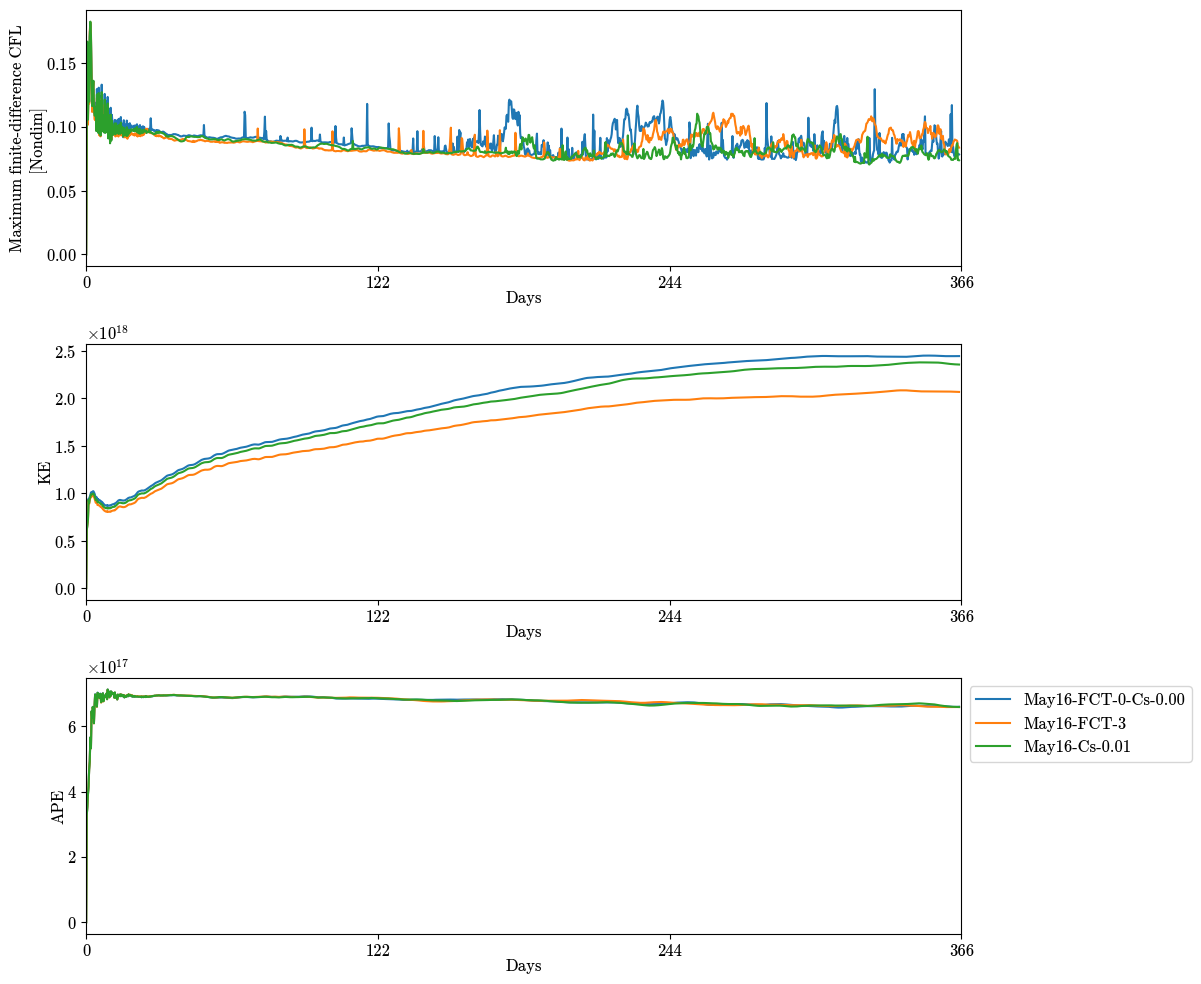

In [69]:
plot_timeseries([
                 #'May16-Cs-0.00', 
                 'May16-FCT-0-Cs-0.00', 
                 'May16-FCT-3',
                 'May16-Cs-0.01'
                ])

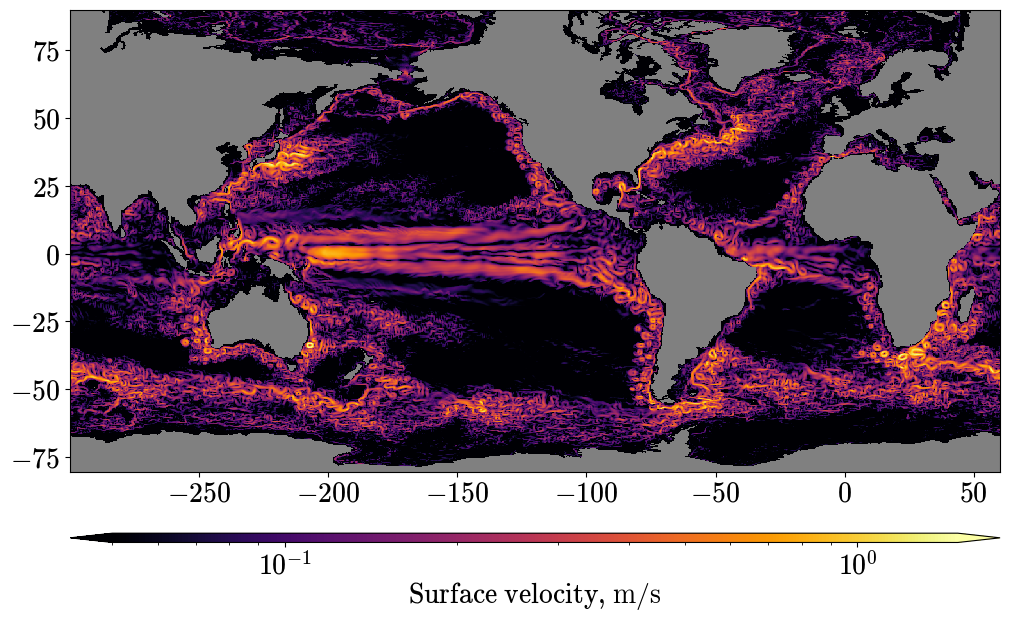

In [17]:
cs1_v = np.sqrt(2*ke_cs1)
default_rcParams({'figure.subplot.wspace': 0.1, 'font.size': 20})
fig, axes = plt.subplots(1,1,figsize=(12,8))#, 
#subplot_kw={'projection': ccrs.PlateCarree()})

# My preset; Equivalent to plotting surface KE
cmap = plt.get_cmap('inferno')
norm = mpl.colors.LogNorm(vmin=0.05, vmax=1.5)
cmap.set_bad('gray')

ax = axes
#ax.coastlines()
#ax.gridlines()
im = cs1_v.isel(time=-1).plot(
    ax=ax,
    norm=norm,
    cmap=cmap,
    add_colorbar=False
)
plt.xlabel('')
plt.ylabel('')
plt.title('')
cb = plt.colorbar(im, pad=0.1, ax=axes, extend='both', aspect=100, shrink=1.0, orientation='horizontal')
cb.set_label(label='Surface velocity, $\mathrm{m}/\mathrm{s}$')
plt.savefig('ANN_global.png', dpi=200)